# GRA_LSTM

1075


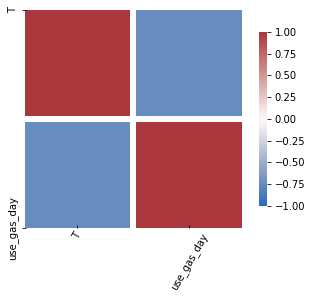

                   T  use_gas_day
date                             
2018-08-28  0.672139     0.000000
2018-08-29  0.685820     0.000058
2018-08-30  0.685820     0.000058
2018-08-31  0.684452     0.023938
2018-09-01  0.684452     0.023938
...              ...          ...
2021-08-02  0.666669     0.016971
2021-08-03  1.000000     0.008998
2021-08-04  1.000000     0.008998
2021-08-05  0.883687     0.001025
2021-08-06  0.883687     0.001025

[1075 rows x 2 columns]


In [27]:
import numpy as np
import pandas as pd
import pymssql
import csv
import tensorflow as tf
#######################
file = pd.read_csv('C:/Users/admin/Desktop/csv/G_Data0000000683.csv')
sql_source = pd.DataFrame(file)
#将csv中的date字符串转化成datetime类型
sql_source.CreateDate = sql_source.CreateDate.astype('datetime64')
#######################
target = pd.DataFrame(columns = ['date','T','use_gas_day'])
i = 0
j = 0
while i<len(sql_source)-1:
    while(i+1<len(sql_source) and sql_source.at[i,'CreateDate'].date()==sql_source.at[i+1,'CreateDate'].date()):
        i = i+1
    j = i+1
    while(j+1<len(sql_source) and sql_source.at[j,'CreateDate'].date()==sql_source.at[j+1,'CreateDate'].date()):
        j = j+1
    if(sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']<0):
        break
    if((sql_source.at[j,'CreateDate'].date()-sql_source.at[i,'CreateDate'].date()).days==1 and sql_source.at[i,'CreateDate'].hour==sql_source.at[j,'CreateDate'].hour and 30>=abs(sql_source.at[i,'CreateDate'].minute-sql_source.at[j,'CreateDate'].minute)>=0 and sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']>0):
        target = target.append([{'date':sql_source.at[j,'CreateDate'].date(),'T':sql_source.at[j,'T'],'use_gas_day':sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']}],ignore_index = True)
    i = j
####################
#处理突兀点
i = 1
while i<len(target)-1:
    a = target.at[i-1,'use_gas_day']
    b = target.at[i,'use_gas_day']
    c = target.at[i+1,'use_gas_day']
    A = abs(b-a)/max(a,b)
    B = abs(c-b)/max(c,b)
    if(A>0.5 and B>0.5):
        target.at[i,'use_gas_day'] = (a+c)/2
    i = i+1
#####################
# Covnert RangeIndex column to 时间戳Index
target = target.reset_index(drop=True).set_index('date')
target.index = pd.DatetimeIndex(target.index)
###################
#补全日期
target = target.resample('D').mean()
target = target.fillna(target.bfill())
print(len(target))
####################
# builds a correlation matrix for the z-scored columns
sca_target = target
sca_target_cor = sca_target.corr()

import seaborn as sns
import matplotlib.pyplot as plt
# creates the figure and axis for the subplots
fig, ax = plt.subplots(figsize=(5, 4))

# plots heatmap
sns_plt = sns.heatmap(sca_target_cor, fmt='.2f', cmap='vlag', linewidths=5, vmin=-1.0, vmax=1.0, cbar_kws={"shrink": .8})
sns_plt.tick_params(labelsize=10,direction='in')
# xtick adjustment
plt.xticks(rotation=60)
plt.show()
#######################
#归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
sca_target['T'] = scaler.fit_transform(sca_target.iloc[:, 0:1])
sca_target['use_gas_day'] = scaler.fit_transform(sca_target.iloc[:, 1:2])
print(sca_target)

In [28]:
def use_gas_day_LSTM_Data_Precesing(df,timestep):    
    features = []
    labels = []
    df = np.array(df)
    date_list = []
    for i in range(timestep, len(sca_target)):
        features.append(df[i-timestep:i,:])
        labels.append(df[i, 1])
        date_list.append(target.index[i])
    features, labels = np.array(features), np.array(labels)
    features = np.reshape(features, (features.shape[0], features.shape[1], -1))
    x_train,x_test,y_train,y_test= features[:900, ],features[900:, ],labels[:900],labels[900:]
    return x_train,x_test,y_train,y_test,date_list

In [29]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [8]:
mem_days = [4]
lstm_layers = [0]
dense_layers = [1]
units = [52]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                
                filepath = './GRA_LSTM/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}' 
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True
                )
                history = LossHistory()
                
                x_train,x_test,y_train,y_test,date_list = use_gas_day_LSTM_Data_Precesing(sca_target,the_mem_days)
                
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                
                model = Sequential()
                model.add(LSTM(the_units,input_shape = (x_train.shape[1], x_train.shape[2]),activation='relu'))
                model.add(Dropout(0.1))
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))

                for i in range(the_dense_layers):
                    model.add(Dense(the_units))
                    model.add(Dropout(0.1))
                model.add(Dense(1))
                
                model.compile(optimizer='adam',loss='mse',metrics=['mape'])
                model.fit(x_train,y_train,batch_size = 32,epochs = 100,shuffle = True,validation_data=(x_test,y_test),callbacks = [checkpoint,history])
                
        

Epoch 1/200
29/29 [==============================] - 1s 10ms/step - loss: 0.0615 - mape: 75.6789 - val_loss: 0.0261 - val_mape: 612.2228
INFO:tensorflow:Assets written to: ./GRA_LSTM\612.22_01_men_4_lstm_0_dense_1_unit_52\assets
Epoch 2/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0128 - mape: 42.8616 - val_loss: 0.0060 - val_mape: 178.1801
INFO:tensorflow:Assets written to: ./GRA_LSTM\178.18_02_men_4_lstm_0_dense_1_unit_52\assets
Epoch 3/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0089 - mape: 26.1009 - val_loss: 0.0061 - val_mape: 186.6402
Epoch 4/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0079 - mape: 24.7906 - val_loss: 0.0061 - val_mape: 191.2059
Epoch 5/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0082 - mape: 24.4877 - val_loss: 0.0060 - val_mape: 191.8250
Epoch 6/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0078 - mape: 23.5714 - val_loss: 0.0063 - val_mape: 171.0317

29/29 [==============================] - 0s 3ms/step - loss: 0.0056 - mape: 15.2445 - val_loss: 0.0043 - val_mape: 50.9643
Epoch 109/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0055 - mape: 15.3671 - val_loss: 0.0043 - val_mape: 56.5977
Epoch 110/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0060 - mape: 14.9816 - val_loss: 0.0043 - val_mape: 80.9040
Epoch 111/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0059 - mape: 15.3007 - val_loss: 0.0046 - val_mape: 49.8354
Epoch 112/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0053 - mape: 15.1811 - val_loss: 0.0047 - val_mape: 102.8075
Epoch 113/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0055 - mape: 16.8916 - val_loss: 0.0044 - val_mape: 31.9992
Epoch 114/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0056 - mape: 14.7565 - val_loss: 0.0050 - val_mape: 94.2820
Epoch 115/200
29/29 [==============================] -

Epoch 168/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0057 - mape: 16.0601 - val_loss: 0.0044 - val_mape: 64.1801
Epoch 169/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0056 - mape: 15.2211 - val_loss: 0.0045 - val_mape: 76.3242
Epoch 170/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0055 - mape: 15.5093 - val_loss: 0.0043 - val_mape: 78.3899
Epoch 171/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0054 - mape: 15.7299 - val_loss: 0.0053 - val_mape: 105.8297
Epoch 172/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0057 - mape: 16.2220 - val_loss: 0.0042 - val_mape: 84.4141
Epoch 173/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0056 - mape: 14.6619 - val_loss: 0.0044 - val_mape: 77.4455
Epoch 174/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0057 - mape: 15.9111 - val_loss: 0.0042 - val_mape: 42.0019
Epoch 175/200
29/29 [===================

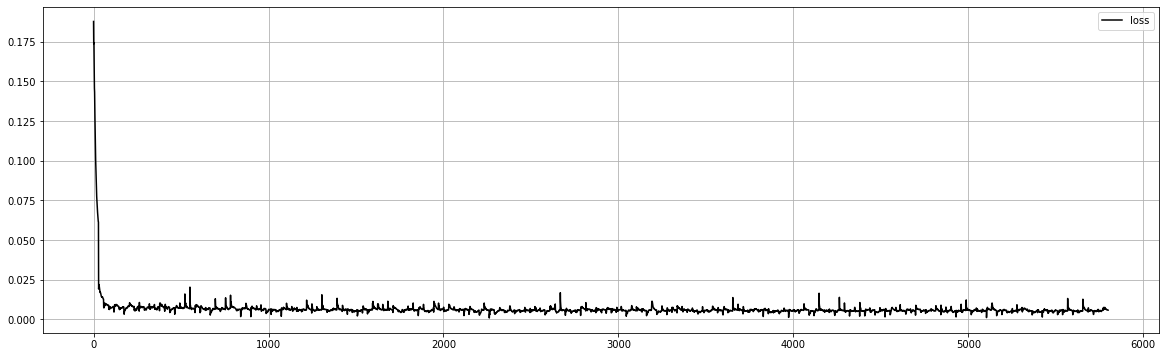

In [30]:
# Visualising the loss
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot()
x = history.losses
ax.plot(x, color = 'black', label = 'loss')
ax.legend()
ax.grid(True)
plt.show()

In [31]:
from tensorflow.keras.models import load_model
best_model = load_model('./GRA_LSTM/18.87_88_men_4_lstm_0_dense_1_unit_52')

predicted_train = best_model.predict(x_train)
predicted_train = scaler.inverse_transform(predicted_train)
predicted_test = best_model.predict(x_test)
predicted_test = scaler.inverse_transform(predicted_test)
real_train=scaler.inverse_transform(np.reshape(y_train,(-1,1)))
real_test=scaler.inverse_transform(np.reshape(y_test,(-1,1)))

best_model.summary()
best_model.evaluate(x_test,y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 52)                11440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 52)                0         
_________________________________________________________________
dense (Dense)                (None, 52)                2756      
_________________________________________________________________
dropout_2 (Dropout)          (None, 52)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 53        
Total params: 14,249
Trainable params: 14,249
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 2ms/step - loss: 0.0045 - mape: 18.8711


[0.0045117042027413845, 18.871105194091797]

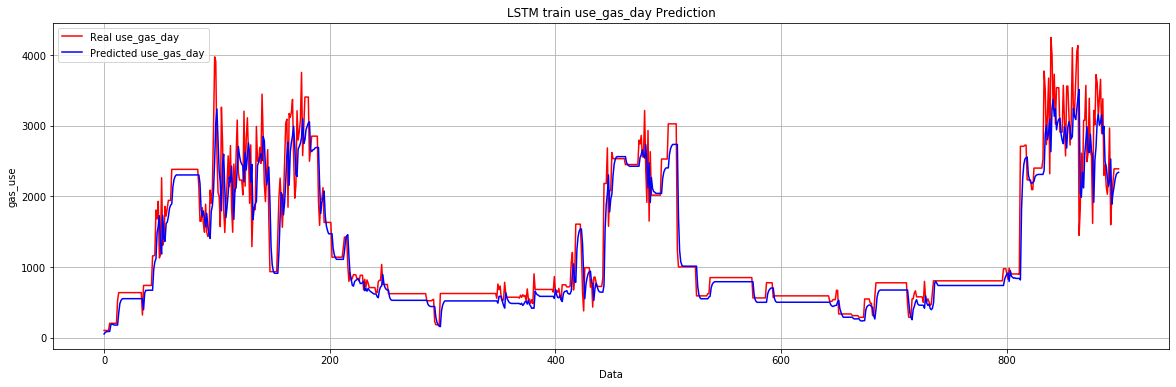

train_mean: 1302.100167
LSTM模型的均方误差是: 99619.806298
LSTM模型的均方根误差是: 315.626055
LSTM模型的平均绝对误差是: 188.891024
LSTM模型的R-squared是: 0.886310


In [32]:
# Visualising the train results
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot()
x = date_list[:900]
ax.plot(real_train, color = 'red', label = 'Real use_gas_day')
ax.plot(predicted_train, color = 'blue', label = 'Predicted use_gas_day')
ax.set_title('LSTM train use_gas_day Prediction')
ax.set_xlabel('Data')
ax.set_ylabel('gas_use')
ax.legend()
ax.grid(True)
plt.show()
######################################################################################################################
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from numpy import *
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
train_mean = mean(real_train)
mse = mean_squared_error(real_train,predicted_train)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(real_train,predicted_train))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(real_train,predicted_train)

r2=r2_score(real_train,predicted_train)

print('train_mean: %.6f' % train_mean)
print('LSTM模型的均方误差是: %.6f' % mse)
print('LSTM模型的均方根误差是: %.6f' % rmse)
print('LSTM模型的平均绝对误差是: %.6f' % mae)
print('LSTM模型的R-squared是: %.6f' % r2)

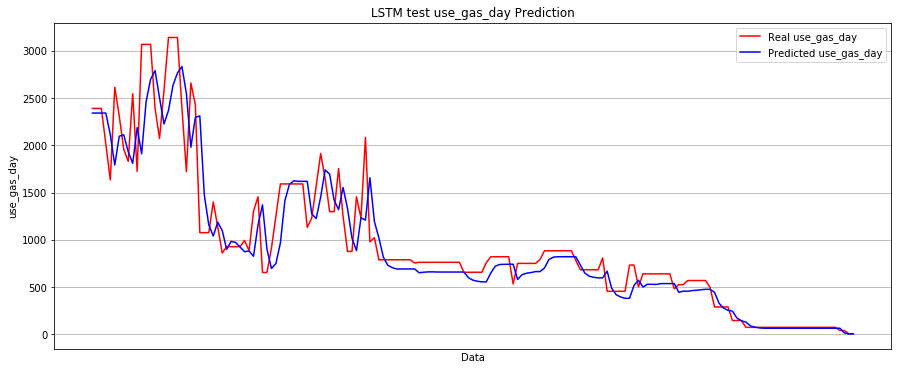

test_mean: 959.823138
LSTM模型的均方误差是: 81516.649358
LSTM模型的均方根误差是: 285.511207
LSTM模型的平均绝对误差是: 177.409468
LSTM模型的R-squared是: 0.854889


In [33]:
# Visualising the test results
import matplotlib.dates as mdates
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot()
x = date_list[900:]
ax.plot(real_test, color = 'red', label = 'Real use_gas_day')
ax.plot(predicted_test, color = 'blue', label = 'Predicted use_gas_day')
ax.set_title('LSTM test use_gas_day Prediction')
ax.set_xlabel('Data')
ax.set_ylabel('use_gas_day')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend()
ax.grid(True)
plt.show()
###############################################################################################################
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
test_mean = mean(real_test)
mse = mean_squared_error(predicted_test, real_test)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(predicted_test, real_test))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(real_test,predicted_test,)
r2=r2_score(real_test,predicted_test)
#r2=r2_score(predicted_test, real_test)
acc = (test_mean-mae)/test_mean
print('test_mean: %.6f' % test_mean)
print('LSTM模型的均方误差是: %.6f' % mse)
print('LSTM模型的均方根误差是: %.6f' % rmse)
print('LSTM模型的平均绝对误差是: %.6f' % mae)
print('LSTM模型的R-squared是: %.6f' % r2)